# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
import statsmodels.api as sm 
import sklearn


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from scipy import stats
from sklearn.model_selection import GridSearchCV
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler,PowerTransformer, RobustScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import kendalltau, f_oneway
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, make_scorer


# Functions

In [2]:
''' We got many null values from scraping so this function will convert null value to Nan values '''

def convert_to_nans(data):
    for i in range(len(data.columns)):
        data.loc[data.iloc[:, i] == "Null", data.columns[i]] = np.nan

In [3]:
def drop_outliers(df, col= "prices"):
    ''' Function for removing outliers but by Specific Lower and upper boundries'''
    IQR = 0
    
    q1 = df[col].quantile(.01)
    q3 = df[col].quantile(.99)
    
    IQR= q3 - q1
    
    lower= q1 - 1.5 * IQR
    upper= q3 + 1.5 * IQR

    
    data_without_outliers = df.drop(df[((df[col] > upper) | (df[col] < lower))].index, axis=0)
    data_without_outliers.reset_index(drop=True, inplace= True)
    
    
#     print(f"Q1 = {q1}" + " " + f"Q3 = {q3}")
    return data_without_outliers


# Load Our Scrapped Data

In [4]:
data = pd.read_csv("final_buy.csv")
data.drop(columns=["Unnamed: 0", "links", 'Type'], inplace = True)
data.reset_index(drop= True, inplace=True)
data

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,Greater Cairo / Arabesque Compound - SED,"3,600,000 EGP","- 24,827 EGP/m",145 m²,3 rooms,3 bathroom,Extra Super Lux,Garden,3,2025,Cash
1,Greater Cairo / Isola Sheraton Compound - El...,"9,500,000 EGP","- 54,285 EGP/m",175 m²,3 rooms,3 bathroom,Semi Finished,Main Street,4,2026,Cash or Installments
2,North Coast / Waterway Resort,"34,636,000 EGP","- 193,497 EGP/m",179 M²,Null,Null,Extra super lux,Seaview,Null,2027,Cash or Installments
3,Greater Cairo / Hyde Park Compound,"126,800,000 EGP","- 184,839 EGP/m",Null,Null,Null,Null,Null,Null,Null,Null
4,Greater Cairo / Scenario Compound - Akam,"7,735,919 EGP","- 51,231 EGP/m",Null,Null,Null,Null,Null,Null,Null,Null
...,...,...,...,...,...,...,...,...,...,...,...
302995,Greater Cairo / Hadayek El Zayton,"1,500,000 EGP","- 12,500 EGP/m",120 m²,3 rooms,1 bathroom,Super Lux,Other,8,2016,Cash
302996,Alexandria / El Falki,"770,000 EGP","- 8,555 EGP/m",90 m²,2 rooms,1 bathroom,Super Lux,Other,8,2021,Cash
302997,Alexandria / Omar Ibn El-Khattab St,"220,000 EGP","- 2,750 EGP/m",80 m²,2 rooms,1 bathroom,Super Lux,Other,3,2017,Cash
302998,Alexandria / El Mandara,"4,500,000 EGP","- 20,454 EGP/m",220 m²,3 rooms,2 bathroom,Super Lux,Other,9,2010,Cash


# Data Cleaning

In [5]:
## Remove Rows with no Details

data.drop(data[(data.iloc[:,3:] == "Null").all(axis=1)].index, axis=0, inplace=True)
data.reset_index(drop= True, inplace=True)

In [6]:
## Convert all Nulls To NaNs
convert_to_nans(data)

In [7]:
## Split columns 

location_data = pd.DataFrame(data= data["locations"].str.split('/', expand= True))[0].str.strip()
price_data = pd.DataFrame(data= data["prices"].str.split(' ', expand= True))[0].str.strip()
priceperm_data = pd.DataFrame(data= data["Price_per_m"].str.split(' ', expand= True))[1].str.strip()
size_data = pd.DataFrame(data= data["sizes"].str.split(' ', expand= True))[0].str.strip()
room_data = pd.DataFrame(data= data["rooms"].str.split(' ', expand= True))[0].str.strip()
bathroom_data = pd.DataFrame(data= data["bathrooms"].str.split(' ', expand= True))[0].str.strip()

## Replacing marks and changing Dtype
data.iloc[:,0] = location_data
data.iloc[:,1] = price_data.str.replace(",", "").astype(float)
data.iloc[:,2] = priceperm_data.str.replace(",", "").astype(float)
data.iloc[:,3] = size_data.astype(float)
data.iloc[:,4] = room_data.astype(float)
data.iloc[:,5] = bathroom_data.astype(float)
data.iloc[:,9] = data["years"].astype(float)

data.reset_index(drop= True, inplace=True)

### Data after Splitting
data

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,Greater Cairo,3600000.0,24827.0,145.0,3.0,3.0,Extra Super Lux,Garden,3,2025.0,Cash
1,Greater Cairo,9500000.0,54285.0,175.0,3.0,3.0,Semi Finished,Main Street,4,2026.0,Cash or Installments
2,North Coast,34636000.0,193497.0,179.0,NaN,NaN,Extra super lux,Seaview,NaN,2027.0,Cash or Installments
3,Greater Cairo,5125000.0,35344.0,145.0,3.0,2.0,Extra Super Lux,Garden,2,2023.0,Cash or Installments
4,Greater Cairo,17607000.0,110735.0,159.0,3.0,NaN,Without Finish,Main Street,3,2026.0,Cash or Installments
...,...,...,...,...,...,...,...,...,...,...,...
299046,Greater Cairo,1500000.0,12500.0,120.0,3.0,1.0,Super Lux,Other,8,2016.0,Cash
299047,Alexandria,770000.0,8555.0,90.0,2.0,1.0,Super Lux,Other,8,2021.0,Cash
299048,Alexandria,220000.0,2750.0,80.0,2.0,1.0,Super Lux,Other,3,2017.0,Cash
299049,Alexandria,4500000.0,20454.0,220.0,3.0,2.0,Super Lux,Other,9,2010.0,Cash


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299051 entries, 0 to 299050
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   locations    299051 non-null  object 
 1   prices       299051 non-null  float64
 2   Price_per_m  299031 non-null  float64
 3   sizes        299051 non-null  float64
 4   rooms        264515 non-null  float64
 5   bathrooms    261603 non-null  float64
 6   finishes     281836 non-null  object 
 7   views        291588 non-null  object 
 8   floors       252943 non-null  object 
 9   years        283140 non-null  float64
 10  payments     297931 non-null  object 
dtypes: float64(6), object(5)
memory usage: 25.1+ MB


In [9]:
data.describe()

,prices,Price_per_m,sizes,rooms,bathrooms,years
count,2.990510e+05,2.990310e+05,2.990510e+05,264515.000000,261603.000000,283140.000000
mean,7.671305e+06,3.284128e+04,1.281021e+04,2.827360,1.785427,2018.808155
std,3.899018e+08,1.353851e+05,3.299348e+06,2.879965,1.451718,49.055329
min,1.000000e+04,0.000000e+00,4.000000e+00,0.000000,0.000000,202.000000
25%,8.500000e+05,7.307000e+03,1.000000e+02,2.000000,1.000000,2017.000000
50%,2.000000e+06,1.419300e+04,1.300000e+02,3.000000,1.000000,2020.000000
75%,6.052000e+06,3.917950e+04,1.750000e+02,3.000000,2.000000,2024.000000
max,2.100000e+11,6.905830e+07,1.260000e+09,858.000000,200.000000,20284.000000


### Imputing NaNs

###### Price Per Meter Square

In [10]:
## Impute NaNs in price per m column using size and prices
data.loc[data["Price_per_m"].isna(), "Price_per_m"] = data["prices"] / data["sizes"]

## Remove Not correct price per meter square
data.drop(data[~(data["Price_per_m"] - data["prices"] / data["sizes"]<100)].index, inplace= True, axis= 0)
data.reset_index(drop= True, inplace= True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299011 entries, 0 to 299010
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   locations    299011 non-null  object 
 1   prices       299011 non-null  float64
 2   Price_per_m  299011 non-null  float64
 3   sizes        299011 non-null  float64
 4   rooms        264493 non-null  float64
 5   bathrooms    261581 non-null  float64
 6   finishes     281813 non-null  object 
 7   views        291548 non-null  object 
 8   floors       252921 non-null  object 
 9   years        283117 non-null  float64
 10  payments     297891 non-null  object 
dtypes: float64(6), object(5)
memory usage: 25.1+ MB


# Encoding

###### Locations

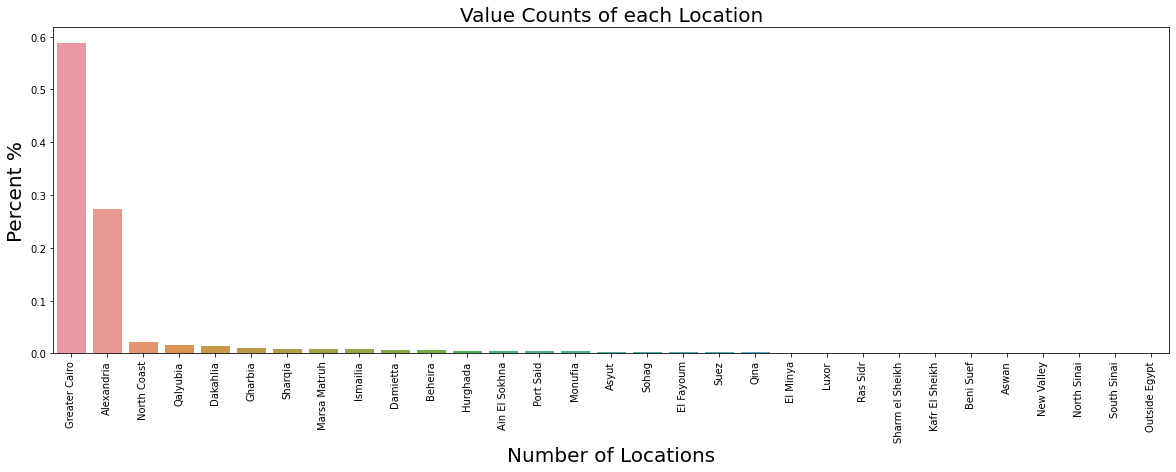

In [12]:
## Visualize Value Counts of each Location
location = data["locations"].value_counts(normalize= True)


plt.figure(figsize=(20,6))
sns.barplot(x= location.index, y= location.values)
plt.title("Value Counts of each Location", fontsize= 20)

plt.xlabel("Number of Locations", fontsize= 20)
plt.xticks(rotation=90)

plt.ylabel("Percent %", fontsize= 20)

plt.show()

In [13]:
# Slice Non Cairo And Alexandria Properties

not_valid_location = data[~((data["locations"] == "Alexandria") | (data["locations"] == "Greater Cairo") | (data["locations"] == "North Coast"))]

## Convert any other locations to 0 value
data.loc[not_valid_location.index, "locations"] = "other"

## Encode other locations
data["locations"].replace("other", 1, inplace= True)
data["locations"].replace("Greater Cairo", 2, inplace= True)
data["locations"].replace("Alexandria", 3, inplace= True)
data["locations"].replace("North Coast", 4, inplace= True)



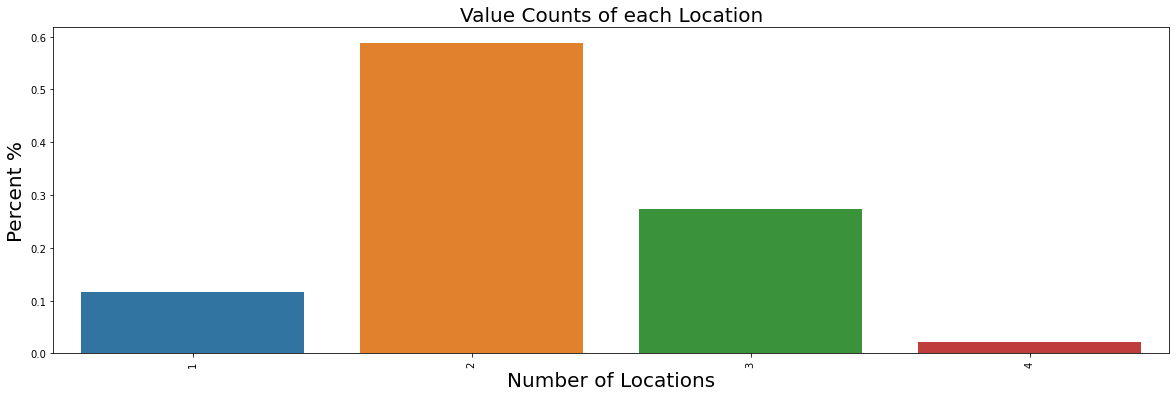

In [14]:
## Visualize Value Counts of each Location
location = data["locations"].value_counts(normalize= True)


plt.figure(figsize=(20,6))
sns.barplot(x= location.index, y= location.values)
plt.title("Value Counts of each Location", fontsize= 20)

plt.xlabel("Number of Locations", fontsize= 20)
plt.xticks(rotation=90)

plt.ylabel("Percent %", fontsize= 20)

plt.show()

###### Rooms

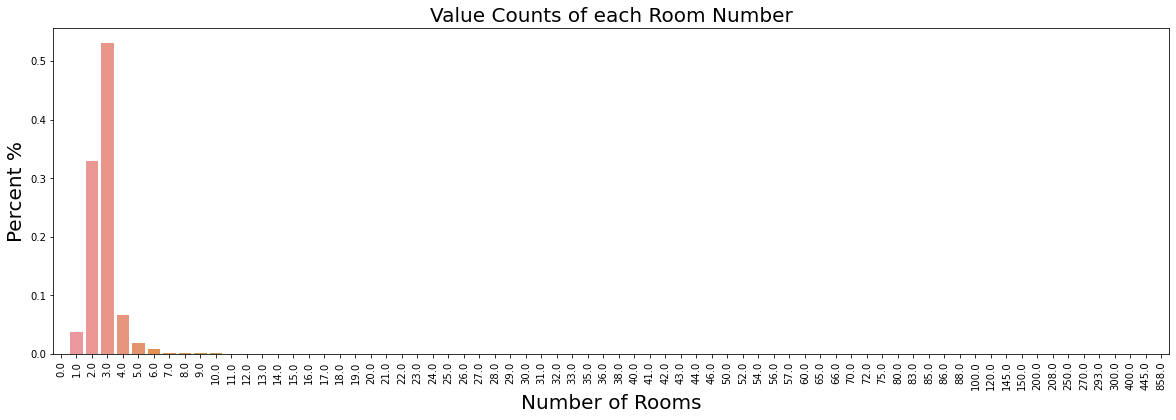

In [15]:
## Visualize Value Counts of Number of Rooms
room = data["rooms"].value_counts(normalize= True).sort_index()

plt.figure(figsize=(20,6))
plt.title("Value Counts of each Room Number", fontsize= 20)
sns.barplot(x= room.index, y= room.values)
plt.xlabel("Number of Rooms" , fontsize=20)
plt.xticks(rotation=90)

plt.ylabel("Percent %", fontsize= 20)

plt.show()

In [16]:
## Took Categories fron 1 to 5 only
data.drop(data[~((data["rooms"] < 6) & (data["rooms"] >0))].index, inplace=True, axis=0)
data.reset_index(drop= True, inplace= True)

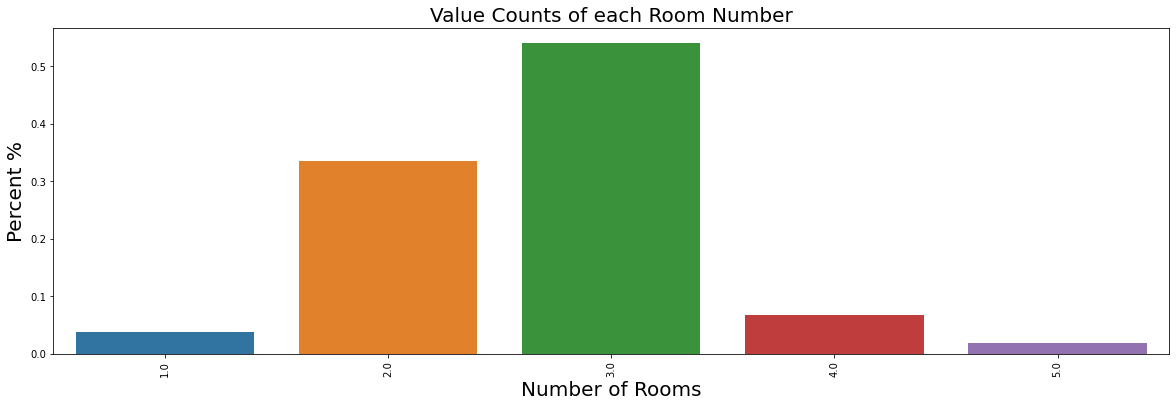

In [17]:
## Visualize Value Counts of Number of Rooms
room = data["rooms"].value_counts(normalize= True).sort_index()

plt.figure(figsize=(20,6))
plt.title("Value Counts of each Room Number", fontsize= 20)
sns.barplot(x= room.index, y= room.values)
plt.xlabel("Number of Rooms" , fontsize=20)
plt.xticks(rotation=90)

plt.ylabel("Percent %", fontsize= 20)

plt.show()

###### Bathrooms

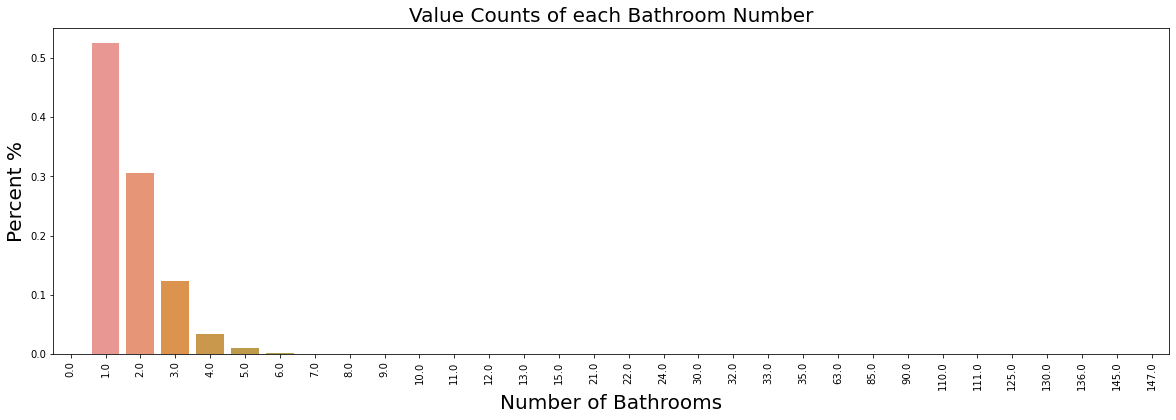

In [18]:
## Visualize Value Counts of Number of Bathooms
bathroom = data["bathrooms"].value_counts(normalize= True).sort_index()

plt.figure(figsize=(20,6))
plt.title("Value Counts of each Bathroom Number", fontsize= 20)
sns.barplot(x= bathroom.index, y= bathroom.values)
plt.xlabel("Number of Bathrooms", fontsize= 20)
plt.xticks(rotation=90)

plt.ylabel("Percent %", fontsize= 20)

plt.show()

In [19]:
## Took Categories fron 1 to 5 only
data.drop(data[~((data["bathrooms"] < 6) & (data["bathrooms"] >0))].index, inplace=True, axis=0)
data.reset_index(drop= True, inplace= True)

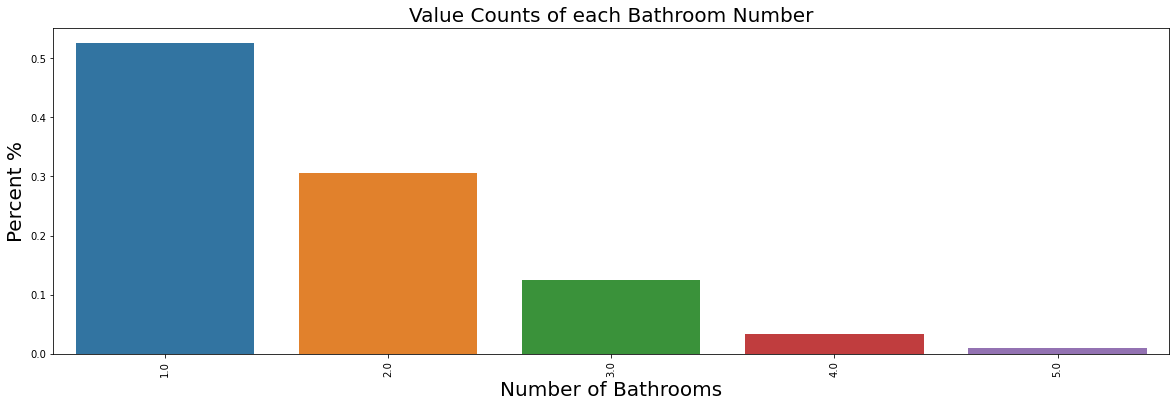

In [20]:
## Visualize Value Counts of Number of Bathooms
bathroom = data["bathrooms"].value_counts(normalize= True).sort_index()

plt.figure(figsize=(20,6))
plt.title("Value Counts of each Bathroom Number", fontsize= 20)
sns.barplot(x= bathroom.index, y= bathroom.values)
plt.xlabel("Number of Bathrooms", fontsize= 20)
plt.xticks(rotation=90)

plt.ylabel("Percent %", fontsize= 20)

plt.show()

###### Floors

In [21]:
## convert ground floor to value 0
data.loc[data["floors"]== "Ground", "floors"] = 0

In [22]:
## Replacing Invalid values to Nans
data["floors"].replace('12,13', np.nan, inplace= True)
data["floors"].replace('9,10', np.nan, inplace= True)
data["floors"].replace('5.6', np.nan, inplace= True)

data["floors"] = data["floors"].astype(float)

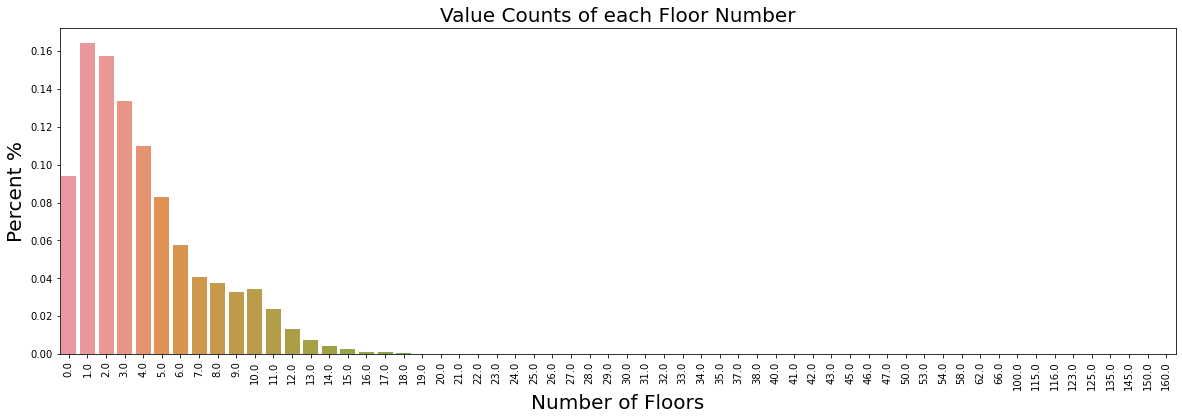

In [23]:
## Visualize Value Counts of each Floor Number
floor = data["floors"].astype(float).value_counts(normalize= True).sort_index()


plt.figure(figsize=(20,6))
plt.title("Value Counts of each Floor Number", fontsize= 20)
sns.barplot(x= floor.index, y= floor.values)
plt.xlabel("Number of Floors", fontsize= 20)
plt.xticks(rotation=90)

plt.ylabel("Percent %", fontsize= 20)

plt.show()

In [24]:
## Took Categories fron 0 to 10 only
data.drop(data[~(data["floors"] < 11)].index, inplace=True, axis=0)
data.reset_index(drop= True, inplace= True)

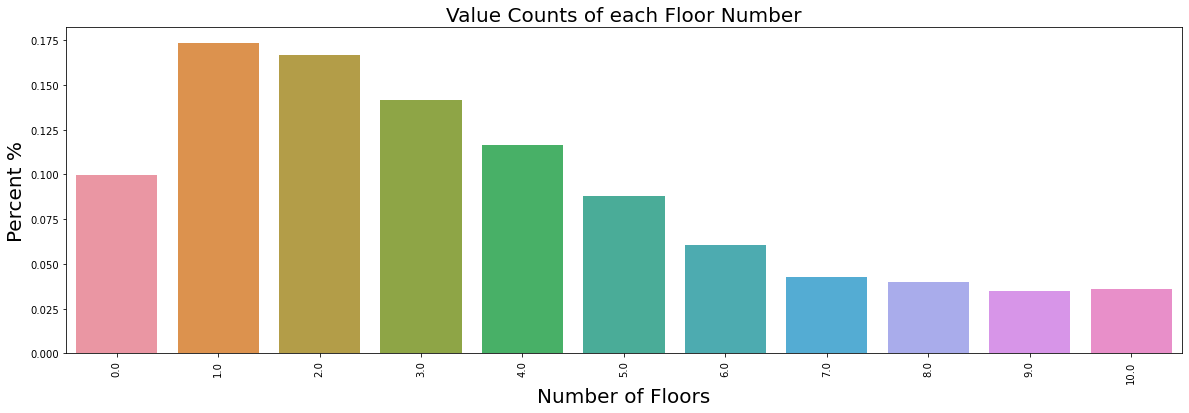

In [25]:
## Visualize Value Counts of each Floor Number
floor = data["floors"].astype(float).value_counts(normalize= True).sort_index()


plt.figure(figsize=(20,6))
plt.title("Value Counts of each Floor Number", fontsize= 20)
sns.barplot(x= floor.index, y= floor.values)
plt.xlabel("Number of Floors", fontsize= 20)
plt.xticks(rotation=90)

plt.ylabel("Percent %", fontsize= 20)

plt.show()

###### Finishes

In [26]:
## Encoding Finish Type

data["finishes"].replace('Without Finish', 1, inplace= True)
data["finishes"].replace('Semi Finished', 2, inplace= True)
data["finishes"].replace('Lux', 3, inplace= True)
data["finishes"].replace('Super Lux', 4, inplace= True)
data["finishes"].replace('Extra Super Lux', 5, inplace= True)

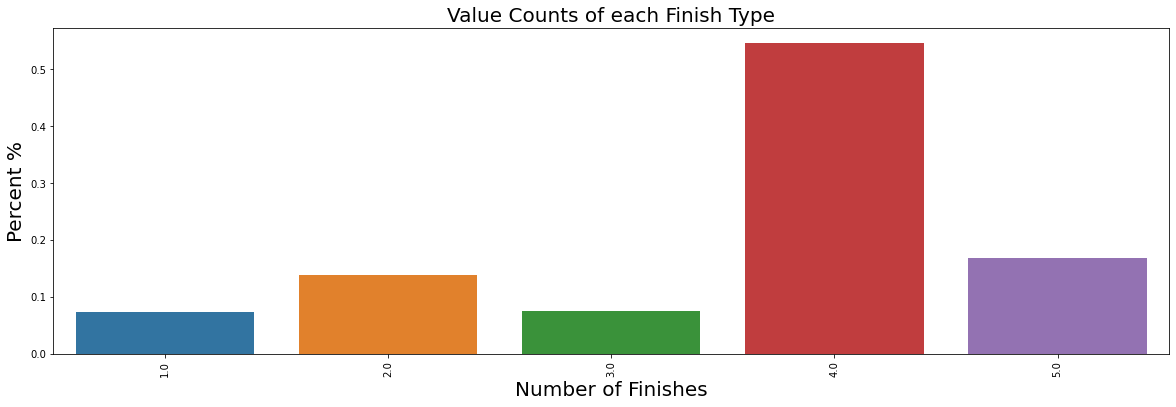

In [27]:
## Visualize Value Counts of each Finish Type Number

finish = data["finishes"].value_counts(normalize= True)

plt.figure(figsize=(20,6))
plt.title("Value Counts of each Finish Type", fontsize= 20)
sns.barplot(x= finish.index, y= finish.values)
plt.xlabel("Number of Finishes", fontsize= 20)
plt.xticks(rotation=90)

plt.ylabel("Percent %", fontsize= 20)

plt.show()

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223984 entries, 0 to 223983
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   locations    223984 non-null  int64  
 1   prices       223984 non-null  float64
 2   Price_per_m  223984 non-null  float64
 3   sizes        223984 non-null  float64
 4   rooms        223984 non-null  float64
 5   bathrooms    223984 non-null  float64
 6   finishes     223983 non-null  float64
 7   views        218787 non-null  object 
 8   floors       223984 non-null  float64
 9   years        223979 non-null  float64
 10  payments     223272 non-null  object 
dtypes: float64(8), int64(1), object(2)
memory usage: 18.8+ MB


###### Views

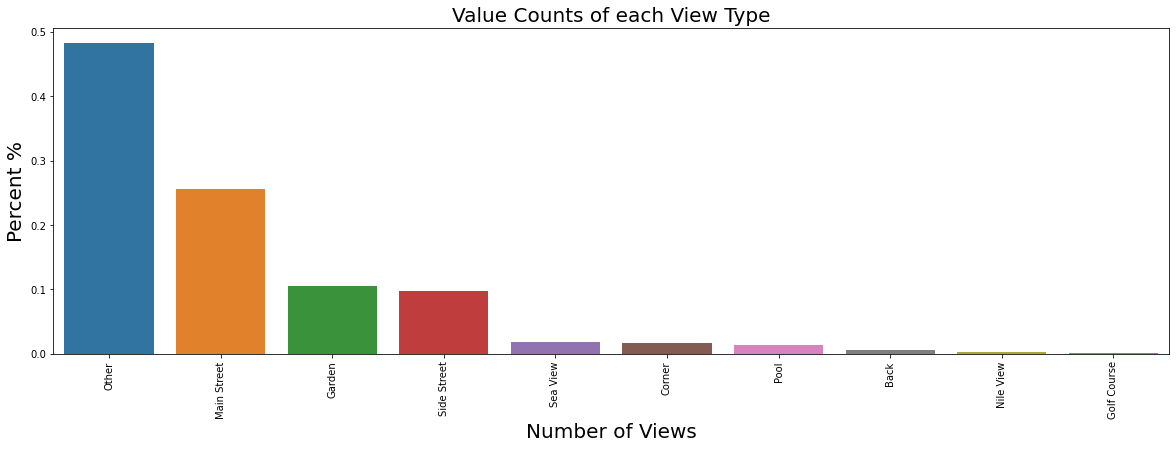

In [29]:
## Visualize Value Counts of View Type Number
view = data["views"].value_counts(normalize= True)

plt.figure(figsize=(20,6))
plt.title("Value Counts of each View Type", fontsize= 20)
sns.barplot(x= view.index, y= view.values)
plt.xlabel("Number of Views", fontsize= 20)
plt.xticks(rotation=90)

plt.ylabel("Percent %", fontsize= 20)

plt.show()

In [30]:
## I will take first 7 categories only and convert others
high_view_cat = data["views"].value_counts()[:7].index
high_view_cat

## convert some views to Other
data.loc[~(data["views"].isin(high_view_cat)), "views"] = "Other"

In [31]:
data["views"].replace('Corner', 1, inplace= True)
data["views"].replace('Garden', 2, inplace= True)
data["views"].replace('Main Street', 3, inplace= True)
data["views"].replace('Other', 4, inplace= True)
data["views"].replace('Pool', 5, inplace= True)
data["views"].replace('Sea View', 6, inplace= True)
data["views"].replace('Side Street', 7, inplace= True)

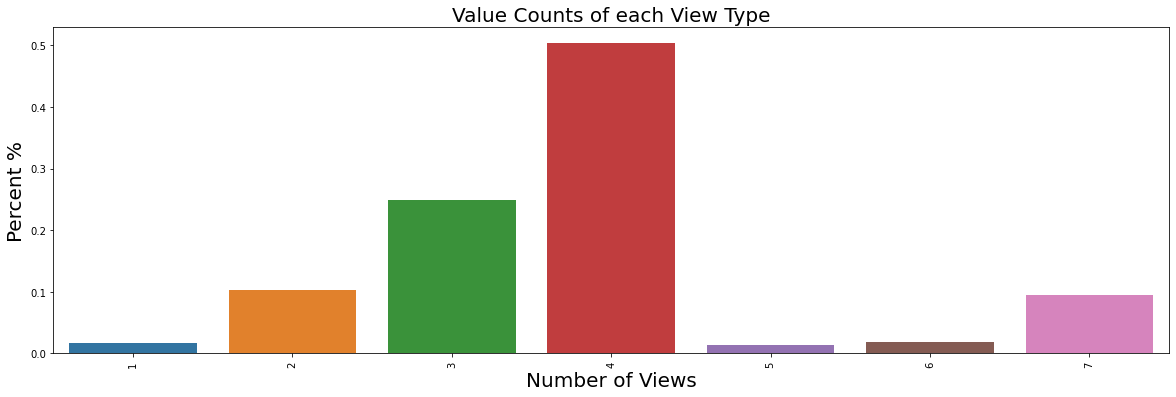

In [32]:
## Visualize Value Counts of View Type Number
view = data["views"].value_counts(normalize= True)

plt.figure(figsize=(20,6))
plt.title("Value Counts of each View Type", fontsize= 20)
sns.barplot(x= view.index, y= view.values)
plt.xlabel("Number of Views", fontsize= 20)
plt.xticks(rotation=90)

plt.ylabel("Percent %", fontsize= 20)

plt.show()

###### Payment

In [33]:
data["payments"].replace('Cash', 1, inplace= True)
data["payments"].replace('Cash or Installments', 2, inplace= True)
data["payments"].replace('Installments', 3, inplace= True)

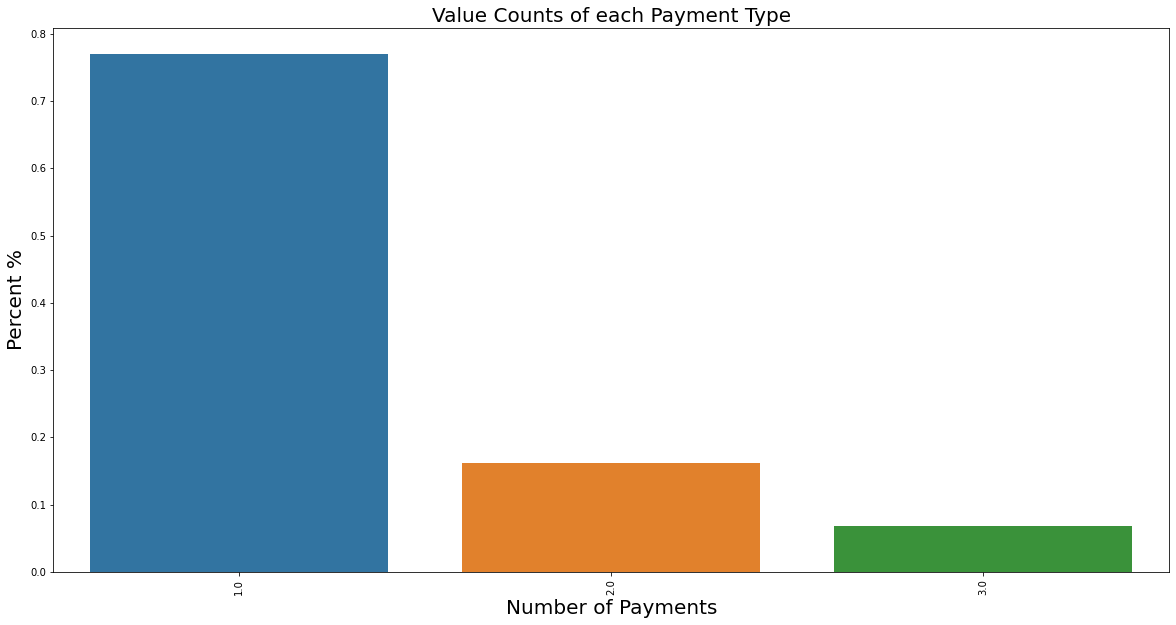

In [34]:
## Visualize Value Counts of each Payment Type Number
payment = data["payments"].value_counts(normalize= True)


plt.figure(figsize=(20,10))
sns.barplot(x= payment.index, y= payment.values)
plt.title("Value Counts of each Payment Type", fontsize= 20)
plt.xlabel("Number of Payments", fontsize= 20)
plt.xticks(rotation=90)

plt.ylabel("Percent %", fontsize= 20)

plt.show()

### Dealing With Outliers

"" Main idea of handling OUTLIERS ""


    Numerical : check if this element is outlier in Numerical Column and Target column (Prices)
    Categorical : check Outlliers in each category based on Target Column (prices)

In [35]:
data

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,2,3600000.0,24827.0,145.0,3.0,3.0,5.0,2,3.0,2025.0,1.0
1,2,9500000.0,54285.0,175.0,3.0,3.0,2.0,3,4.0,2026.0,2.0
2,2,5125000.0,35344.0,145.0,3.0,2.0,5.0,2,2.0,2023.0,2.0
3,4,7100000.0,48965.0,145.0,2.0,2.0,5.0,6,2.0,2025.0,3.0
4,2,9700000.0,75781.0,128.0,2.0,2.0,1.0,3,2.0,2026.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
223979,2,1500000.0,12500.0,120.0,3.0,1.0,4.0,4,8.0,2016.0,1.0
223980,3,770000.0,8555.0,90.0,2.0,1.0,4.0,4,8.0,2021.0,1.0
223981,3,220000.0,2750.0,80.0,2.0,1.0,4.0,4,3.0,2017.0,1.0
223982,3,4500000.0,20454.0,220.0,3.0,2.0,4.0,4,9.0,2010.0,1.0


In [36]:
## Handling Types of our features

data.iloc[:,1] = data.iloc[:,1].astype(float)
data.iloc[:,2] = data.iloc[:,2].astype(float)
data.iloc[:,3] = data.iloc[:,3].astype(int)
data.iloc[:,4] = data.iloc[:,4].astype(int)
data.iloc[:,5] = data.iloc[:,5].astype(int)
data.iloc[:,8] = data.iloc[:,8].astype(int)
data.iloc[:,9] = data.iloc[:,9].astype(float)

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223984 entries, 0 to 223983
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   locations    223984 non-null  int64  
 1   prices       223984 non-null  float64
 2   Price_per_m  223984 non-null  float64
 3   sizes        223984 non-null  int32  
 4   rooms        223984 non-null  int32  
 5   bathrooms    223984 non-null  int32  
 6   finishes     223983 non-null  float64
 7   views        223984 non-null  int64  
 8   floors       223984 non-null  int32  
 9   years        223979 non-null  float64
 10  payments     223272 non-null  float64
dtypes: float64(5), int32(4), int64(2)
memory usage: 15.4 MB


###### Sizes

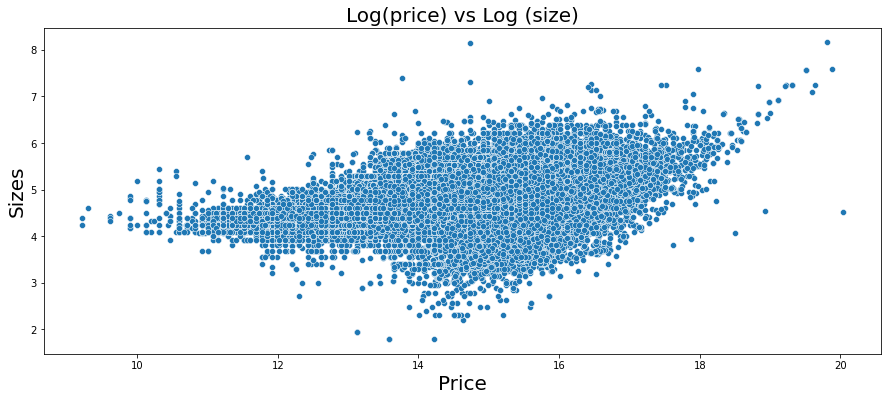

In [38]:
## Correlation between Sizes and prices

plt.figure(figsize=(15,6))
plt.title("Log(price) vs Log (size)", fontsize= 20)

sns.scatterplot(x= np.log(data["prices"]), y= np.log(data["sizes"]))

plt.xlabel("Price", fontsize= 20)
plt.ylabel("Sizes", fontsize= 20)

plt.show()

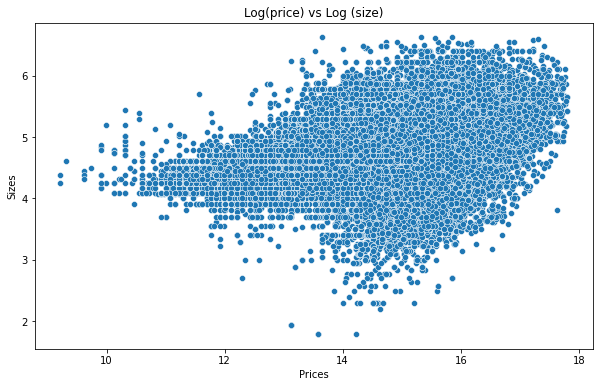

In [40]:
## Removing Outliers From Numerical Column

data_without_outliers = drop_outliers(data, "prices")
data_without_outliers = drop_outliers(data_without_outliers, "sizes")

plt.figure(figsize=(10,6))
plt.title("Log(price) vs Log (size)")
sns.scatterplot(x= np.log(data_without_outliers["prices"]), y= np.log(data_without_outliers["sizes"]))

plt.xlabel("Prices")
plt.ylabel("Sizes")

plt.show()

In [41]:
data_without_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223749 entries, 0 to 223748
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   locations    223749 non-null  int64  
 1   prices       223749 non-null  float64
 2   Price_per_m  223749 non-null  float64
 3   sizes        223749 non-null  int32  
 4   rooms        223749 non-null  int32  
 5   bathrooms    223749 non-null  int32  
 6   finishes     223748 non-null  float64
 7   views        223749 non-null  int64  
 8   floors       223749 non-null  int32  
 9   years        223744 non-null  float64
 10  payments     223040 non-null  float64
dtypes: float64(5), int32(4), int64(2)
memory usage: 15.4 MB


###### Rooms

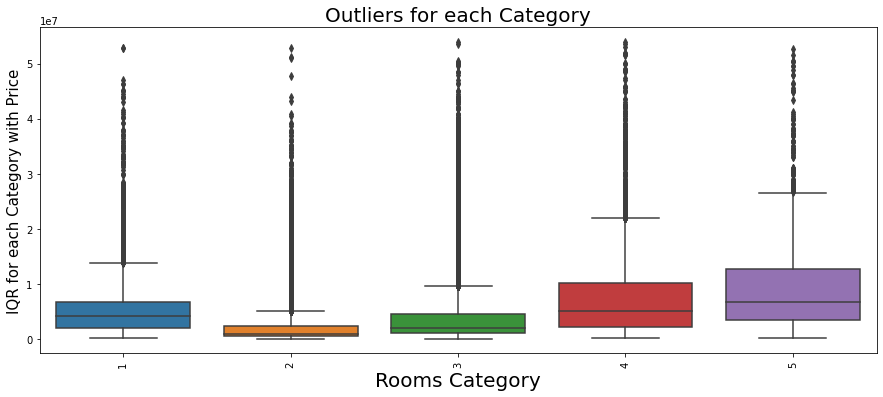

In [42]:
## Outliers for each Category
plt.figure(figsize=(15,6))
plt.title("Outliers for each Category", fontsize= 20)
sns.boxplot(x = data_without_outliers["rooms"], y= data_without_outliers["prices"])

plt.xlabel("Rooms Category", fontsize= 20)
plt.xticks(rotation=90)
plt.ylabel("IQR for each Category with Price", fontsize= 15)

plt.show()

In [43]:
## Drop Outliers from Categorical Featrue

data_without_outliers = data_without_outliers.groupby("rooms").apply(drop_outliers)
data_without_outliers.reset_index(drop= True, inplace= True)
data_without_outliers

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,2,4504500.0,49500.0,91,1,1,2.0,2,0,2027.0,2.0
1,4,3000000.0,33707.0,89,1,1,5.0,6,2,2025.0,2.0
2,2,7310000.0,83068.0,88,1,2,2.0,2,1,2024.0,3.0
3,4,900000.0,22500.0,40,1,1,5.0,5,1,2025.0,3.0
4,2,3000000.0,142857.0,21,1,1,5.0,3,3,2025.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
223734,3,1250000.0,4464.0,280,5,3,4.0,4,2,2022.0,1.0
223735,3,790000.0,3950.0,200,5,2,4.0,4,0,2009.0,1.0
223736,2,5000000.0,17857.0,280,5,3,4.0,3,0,2020.0,1.0
223737,3,2500000.0,3846.0,650,5,3,4.0,4,9,2007.0,1.0


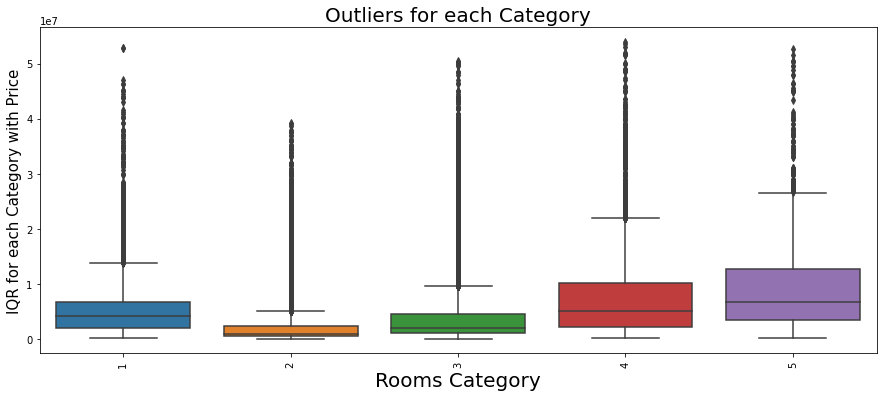

In [44]:
## Outliers for each Category
plt.figure(figsize=(15,6))
plt.title("Outliers for each Category", fontsize= 20)
sns.boxplot(x = data_without_outliers["rooms"], y= data_without_outliers["prices"])

plt.xlabel("Rooms Category", fontsize= 20)
plt.xticks(rotation=90)
plt.ylabel("IQR for each Category with Price", fontsize= 15)

plt.show()

###### Bathrooms

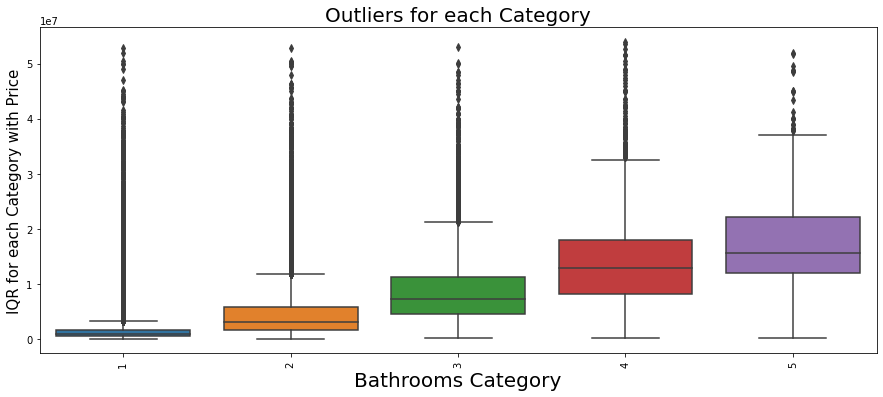

In [45]:
## Outliers for each Category
plt.figure(figsize=(15,6))
plt.title("Outliers for each Category", fontsize= 20)
sns.boxplot(x = data_without_outliers["bathrooms"], y= data_without_outliers["prices"])

plt.xlabel("Bathrooms Category", fontsize= 20)
plt.xticks(rotation=90)
plt.ylabel("IQR for each Category with Price", fontsize= 15)

plt.show()

In [46]:
data_without_outliers = data_without_outliers.groupby("bathrooms").apply(drop_outliers)
data_without_outliers.reset_index(drop= True, inplace= True)
data_without_outliers

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,2,4504500.0,49500.0,91,1,1,2.0,2,0,2027.0,2.0
1,4,3000000.0,33707.0,89,1,1,5.0,6,2,2025.0,2.0
2,4,900000.0,22500.0,40,1,1,5.0,5,1,2025.0,3.0
3,2,3000000.0,142857.0,21,1,1,5.0,3,3,2025.0,3.0
4,2,11736515.0,138076.0,85,1,1,2.0,2,0,2026.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
223605,2,14500000.0,46774.0,310,5,5,4.0,7,8,2019.0,1.0
223606,2,11000000.0,20000.0,550,5,5,4.0,4,1,2020.0,1.0
223607,3,27500000.0,70512.0,390,5,5,5.0,6,6,2021.0,1.0
223608,3,27500000.0,70512.0,390,5,5,5.0,6,1,2021.0,1.0


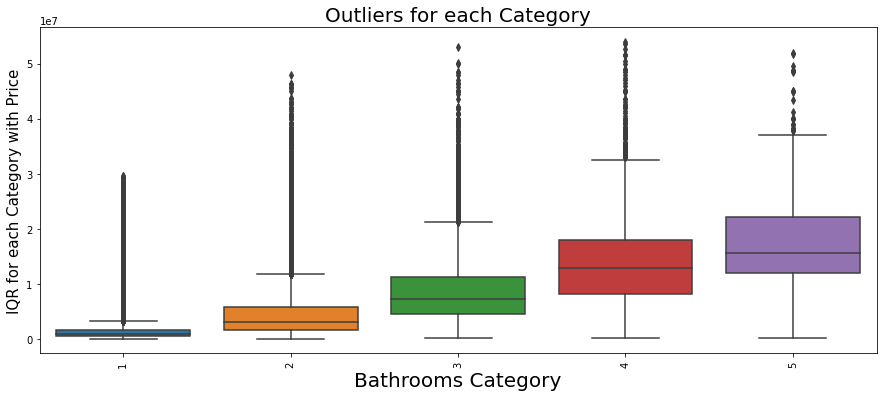

In [47]:
## Outliers for each Category
plt.figure(figsize=(15,6))
plt.title("Outliers for each Category", fontsize= 20)
sns.boxplot(x = data_without_outliers["bathrooms"], y= data_without_outliers["prices"])

plt.xlabel("Bathrooms Category", fontsize= 20)
plt.xticks(rotation=90)
plt.ylabel("IQR for each Category with Price", fontsize= 15)

plt.show()

###### Floors

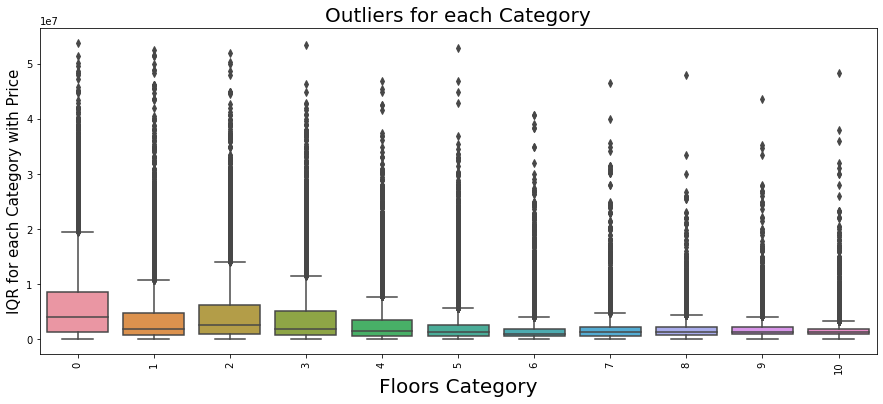

In [48]:
## Outliers for each Category
plt.figure(figsize=(15,6))
plt.title("Outliers for each Category", fontsize= 20)
sns.boxplot(x = data_without_outliers["floors"], y= data_without_outliers["prices"])

plt.xlabel("Floors Category", fontsize= 20)
plt.xticks(rotation=90)
plt.ylabel("IQR for each Category with Price", fontsize= 15)

plt.show()

In [49]:
data_without_outliers = data_without_outliers.groupby("floors").apply(drop_outliers)
data_without_outliers.reset_index(drop= True, inplace= True)
data_without_outliers

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,2,4504500.0,49500.0,91,1,1,2.0,2,0,2027.0,2.0
1,2,11736515.0,138076.0,85,1,1,2.0,2,0,2026.0,2.0
2,1,5250000.0,95454.0,55,1,1,5.0,3,0,2025.0,2.0
3,1,1100000.0,18333.0,60,1,1,1.0,7,0,2024.0,1.0
4,2,3200000.0,50000.0,64,1,1,2.0,2,0,2025.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
223579,3,17500000.0,53030.0,330,4,5,4.0,4,10,2004.0,1.0
223580,2,9000000.0,18000.0,500,5,5,4.0,4,10,2021.0,1.0
223581,2,7500000.0,17857.0,420,5,5,3.0,3,10,2000.0,1.0
223582,2,30000000.0,82191.0,365,5,5,5.0,4,10,2018.0,2.0


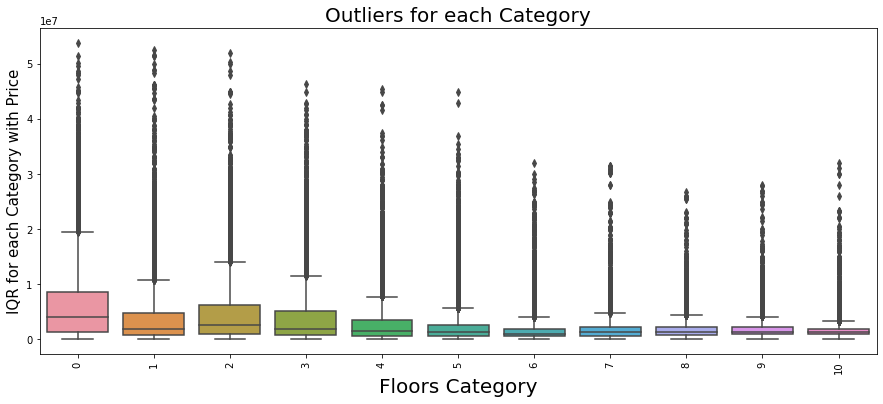

In [50]:
## Outliers for each Category
plt.figure(figsize=(15,6))
plt.title("Outliers for each Category", fontsize= 20)
sns.boxplot(x = data_without_outliers["floors"], y= data_without_outliers["prices"])

plt.xlabel("Floors Category", fontsize= 20)
plt.xticks(rotation=90)
plt.ylabel("IQR for each Category with Price", fontsize= 15)

plt.show()

###### Years

In [51]:
data_without_outliers["property_age"] = 2024 - data_without_outliers["years"]
data_without_outliers

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments,property_age
0,2,4504500.0,49500.0,91,1,1,2.0,2,0,2027.0,2.0,-3.0
1,2,11736515.0,138076.0,85,1,1,2.0,2,0,2026.0,2.0,-2.0
2,1,5250000.0,95454.0,55,1,1,5.0,3,0,2025.0,2.0,-1.0
3,1,1100000.0,18333.0,60,1,1,1.0,7,0,2024.0,1.0,0.0
4,2,3200000.0,50000.0,64,1,1,2.0,2,0,2025.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
223579,3,17500000.0,53030.0,330,4,5,4.0,4,10,2004.0,1.0,20.0
223580,2,9000000.0,18000.0,500,5,5,4.0,4,10,2021.0,1.0,3.0
223581,2,7500000.0,17857.0,420,5,5,3.0,3,10,2000.0,1.0,24.0
223582,2,30000000.0,82191.0,365,5,5,5.0,4,10,2018.0,2.0,6.0


###### Drop Sizes

In [52]:
# Drop prices per square meter column and let Size Column
data_without_outliers.drop(columns=["sizes"], inplace= True, axis=1)
# data_without_outliers.drop(columns=["years"], inplace= True, axis=1)

data_without_outliers.reset_index(drop= True, inplace= True)
data_without_outliers

,locations,prices,Price_per_m,rooms,bathrooms,finishes,views,floors,years,payments,property_age
0,2,4504500.0,49500.0,1,1,2.0,2,0,2027.0,2.0,-3.0
1,2,11736515.0,138076.0,1,1,2.0,2,0,2026.0,2.0,-2.0
2,1,5250000.0,95454.0,1,1,5.0,3,0,2025.0,2.0,-1.0
3,1,1100000.0,18333.0,1,1,1.0,7,0,2024.0,1.0,0.0
4,2,3200000.0,50000.0,1,1,2.0,2,0,2025.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
223579,3,17500000.0,53030.0,4,5,4.0,4,10,2004.0,1.0,20.0
223580,2,9000000.0,18000.0,5,5,4.0,4,10,2021.0,1.0,3.0
223581,2,7500000.0,17857.0,5,5,3.0,3,10,2000.0,1.0,24.0
223582,2,30000000.0,82191.0,5,5,5.0,4,10,2018.0,2.0,6.0


# Removing Inflation Process
- Before we start we should convert our prices to uninflated prices (Adjusted_Price).
- My inflation rates data is from 2005 to 2025 so we will work on data in this period.
- From inflation rate data we will use ***Core*** column
- From inflation rates data we will get Consumer Price Index (CPI).

In [53]:
inflation_rate = pd.read_excel("Inflations Historical.xlsx", header=1)
inflation_rate = inflation_rate.iloc[0:241:]
inflation_rate

,Date,Headline (y/y),Core (y/y),Regulated Items (y/y),Fruits and Vegetables (y/y)
0,Jan 2025,23.950%,22.590%,29.890%,20.890%
1,Dec 2024,24.060%,23.220%,31.250%,11.830%
2,Nov 2024,25.540%,23.710%,30.750%,30.000%
3,Oct 2024,26.531%,24.404%,31.810%,34.190%
4,Sep 2024,26.397%,24.966%,30.242%,30.290%
...,...,...,...,...,...
236,May 2005,5.081%,4.103%,7.638%,5.672%
237,Apr 2005,4.604%,4.530%,7.546%,-2.573%
238,Mar 2005,5.527%,5.995%,7.637%,-3.476%
239,Feb 2005,6.729%,6.144%,10.852%,0.014%


In [54]:
## Handling Core column for Splitting and Save in New Dataframe

inflation = pd.DataFrame()
inflation["date_inflation"] = inflation_rate["Date"].str.split(" ", expand= True)[1]
inflation["core_inflation"] = inflation_rate["Core (y/y)"].str.split("%", expand= True)[0]
inflation

,date_inflation,core_inflation
0,2025,22.590
1,2024,23.220
2,2024,23.710
3,2024,24.404
4,2024,24.966
...,...,...
236,2005,4.103
237,2005,4.530
238,2005,5.995
239,2005,6.144


In [55]:
## Changing Type of the Inflation Data
inflation.iloc[:,0] = inflation.iloc[:,0].astype(int)
inflation.iloc[:,1] = inflation.iloc[:,1].astype(float)

inflation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date_inflation  241 non-null    int32  
 1   core_inflation  241 non-null    float64
dtypes: float64(1), int32(1)
memory usage: 2.9 KB


In [56]:
# Calculate the Mean of Core Inflation for each year

cpi_by_year = inflation.groupby("date_inflation")["core_inflation"].mean()
cpi_by_year = pd.DataFrame(cpi_by_year)
cpi_by_year

,core_inflation
date_inflation,
2005,4.022500
2006,6.196583
2007,8.013917
2008,18.931833
2009,8.958508
2010,7.570833
2011,8.302925
2012,6.186917
2013,9.015750


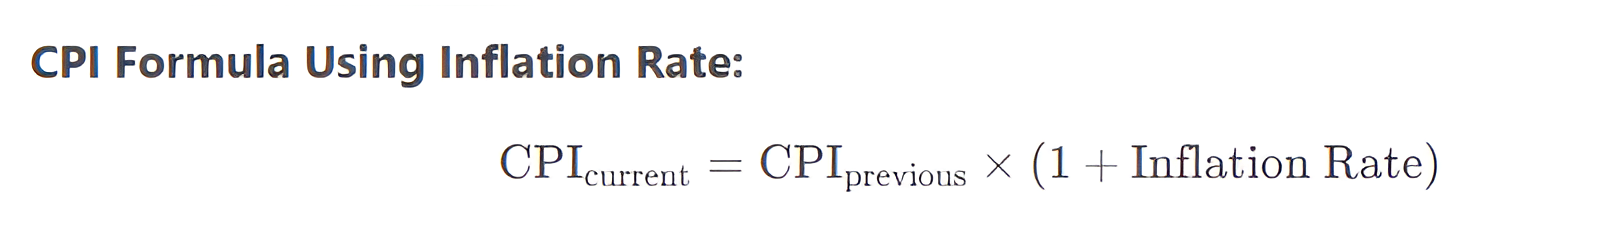

In [57]:
## Calcuate CPI for each Year and the base is **2005**

cpi = [1]
for i in range(1, len(cpi_by_year)):
    cpi.append(cpi[i-1] * (1 + cpi_by_year.loc[2004 + i, 'core_inflation']/100))
cpi_by_year['CPI'] = cpi
cpi_by_year

,core_inflation,CPI
date_inflation,,
2005,4.022500,1.000000
2006,6.196583,1.040225
2007,8.013917,1.104683
2008,18.931833,1.193212
2009,8.958508,1.419109
2010,7.570833,1.546240
2011,8.302925,1.663303
2012,6.186917,1.801406
2013,9.015750,1.912857


In [58]:
## Merging the CPI Column to our Data
data_inflated = data_without_outliers.merge(cpi_by_year, how= "left", left_on="years", right_index= True)
## Remove the data Befor 2005
data_inflated = data_inflated[(data_inflated["years"] >= 2005)]
data_inflated

,locations,prices,Price_per_m,rooms,bathrooms,finishes,views,floors,years,payments,property_age,core_inflation,CPI
0,2,4504500.0,49500.0,1,1,2.0,2,0,2027.0,2.0,-3.0,NaN,NaN
1,2,11736515.0,138076.0,1,1,2.0,2,0,2026.0,2.0,-2.0,NaN,NaN
2,1,5250000.0,95454.0,1,1,5.0,3,0,2025.0,2.0,-1.0,22.590000,9.108303
3,1,1100000.0,18333.0,1,1,1.0,7,0,2024.0,1.0,0.0,27.431583,7.147603
4,2,3200000.0,50000.0,1,1,2.0,2,0,2025.0,1.0,-1.0,22.590000,9.108303
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223576,3,23316800.0,61360.0,4,5,5.0,2,10,2027.0,3.0,-3.0,NaN,NaN
223577,2,8500000.0,36956.0,4,5,4.0,3,10,2016.0,1.0,8.0,13.296167,2.436150
223578,3,17000000.0,51515.0,4,5,4.0,6,10,2020.0,1.0,4.0,2.336500,4.210838
223580,2,9000000.0,18000.0,5,5,4.0,4,10,2021.0,1.0,3.0,4.372250,4.309224


In [59]:
## Our Base Year will Be 2024 that's Mean we will convert all prices to 2024 Prices
cpi_2024_base = cpi_by_year[cpi_by_year.index == 2024]["CPI"].values[0]

## Any year after 2025 will have CPI = the CPI of 2025
cpi_2025= cpi_by_year[cpi_by_year.index == 2025]["CPI"].values[0]
data_inflated.loc[data_inflated["years"] >= 2025, "CPI"] = cpi_2025 

In [60]:
## Calculate Adujusted price Column

data_inflated['Adjusted_Price'] = data_inflated['prices'] * (cpi_2024_base / data_inflated['CPI'])
data_inflated.reset_index(drop= True, inplace= True)
data_inflated

,locations,prices,Price_per_m,rooms,bathrooms,finishes,views,floors,years,payments,property_age,core_inflation,CPI,Adjusted_Price
0,2,4504500.0,49500.0,1,1,2.0,2,0,2027.0,2.0,-3.0,NaN,9.108303,3.534838e+06
1,2,11736515.0,138076.0,1,1,2.0,2,0,2026.0,2.0,-2.0,NaN,9.108303,9.210052e+06
2,1,5250000.0,95454.0,1,1,5.0,3,0,2025.0,2.0,-1.0,22.590000,9.108303,4.119858e+06
3,1,1100000.0,18333.0,1,1,1.0,7,0,2024.0,1.0,0.0,27.431583,7.147603,1.100000e+06
4,2,3200000.0,50000.0,1,1,2.0,2,0,2025.0,1.0,-1.0,22.590000,9.108303,2.511151e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208366,3,23316800.0,61360.0,4,5,5.0,2,10,2027.0,3.0,-3.0,NaN,9.108303,1.829750e+07
208367,2,8500000.0,36956.0,4,5,4.0,3,10,2016.0,1.0,8.0,13.296167,2.436150,2.493878e+07
208368,3,17000000.0,51515.0,4,5,4.0,6,10,2020.0,1.0,4.0,2.336500,4.210838,2.885631e+07
208369,2,9000000.0,18000.0,5,5,4.0,4,10,2021.0,1.0,3.0,4.372250,4.309224,1.492808e+07


In [61]:
data_inflated["Adjusted_Price"].dropna(inplace= True)

In [62]:
data_inflated.drop(data_inflated[data_inflated["years"] > 2040].index, axis= 0, inplace= True)
data_inflated.reset_index(drop= True, inplace= True)
data_inflated

,locations,prices,Price_per_m,rooms,bathrooms,finishes,views,floors,years,payments,property_age,core_inflation,CPI,Adjusted_Price
0,2,4504500.0,49500.0,1,1,2.0,2,0,2027.0,2.0,-3.0,NaN,9.108303,3.534838e+06
1,2,11736515.0,138076.0,1,1,2.0,2,0,2026.0,2.0,-2.0,NaN,9.108303,9.210052e+06
2,1,5250000.0,95454.0,1,1,5.0,3,0,2025.0,2.0,-1.0,22.590000,9.108303,4.119858e+06
3,1,1100000.0,18333.0,1,1,1.0,7,0,2024.0,1.0,0.0,27.431583,7.147603,1.100000e+06
4,2,3200000.0,50000.0,1,1,2.0,2,0,2025.0,1.0,-1.0,22.590000,9.108303,2.511151e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208303,3,23316800.0,61360.0,4,5,5.0,2,10,2027.0,3.0,-3.0,NaN,9.108303,1.829750e+07
208304,2,8500000.0,36956.0,4,5,4.0,3,10,2016.0,1.0,8.0,13.296167,2.436150,2.493878e+07
208305,3,17000000.0,51515.0,4,5,4.0,6,10,2020.0,1.0,4.0,2.336500,4.210838,2.885631e+07
208306,2,9000000.0,18000.0,5,5,4.0,4,10,2021.0,1.0,3.0,4.372250,4.309224,1.492808e+07


In [173]:
def drop_outliers_for_numerical(df, col):
    IQR = 0
    q1 = df[col].quantile(.02)
    q3 = df[col].quantile(.98)
    IQR= q3 - q1
    
    lower= q1 - 1.5 * IQR
    upper= q3 + 1.5 * IQR
    
    data_without_outliers = df.drop(df[((df[col] > upper) | (df[col] < lower))].index, axis=0)
    data_without_outliers.reset_index(drop=True, inplace= True)

    return data_without_outliers

data_inflated = drop_outliers_for_numerical(data_inflated, "Adjusted_Price")
data_inflated

,locations,prices,Price_per_m,rooms,bathrooms,finishes,views,floors,years,payments,property_age,core_inflation,CPI,Adjusted_Price
0,2,4504500.0,49500.0,1,1,2.0,2,0,2027.0,2.0,-3.0,NaN,9.108303,3.534838e+06
1,2,11736515.0,138076.0,1,1,2.0,2,0,2026.0,2.0,-2.0,NaN,9.108303,9.210052e+06
2,1,5250000.0,95454.0,1,1,5.0,3,0,2025.0,2.0,-1.0,22.590000,9.108303,4.119858e+06
3,1,1100000.0,18333.0,1,1,1.0,7,0,2024.0,1.0,0.0,27.431583,7.147603,1.100000e+06
4,2,3200000.0,50000.0,1,1,2.0,2,0,2025.0,1.0,-1.0,22.590000,9.108303,2.511151e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207378,2,19383376.0,80096.0,4,5,4.0,4,10,2025.0,3.0,-1.0,22.590000,9.108303,1.521081e+07
207379,3,23316800.0,61360.0,4,5,5.0,2,10,2027.0,3.0,-3.0,NaN,9.108303,1.829750e+07
207380,2,8500000.0,36956.0,4,5,4.0,3,10,2016.0,1.0,8.0,13.296167,2.436150,2.493878e+07
207381,3,17000000.0,51515.0,4,5,4.0,6,10,2020.0,1.0,4.0,2.336500,4.210838,2.885631e+07


# Missing Values

In [174]:
data_inflated.isna().sum()

locations             0
prices                0
Price_per_m           0
rooms                 0
bathrooms             0
finishes              0
views                 0
floors                0
years                 0
payments              0
property_age          0
core_inflation    25605
CPI                   0
Adjusted_Price        0
dtype: int64

In [64]:
data_inflated.drop(data_inflated[data_inflated.loc[:, "payments"].isna()].index, inplace= True)
data_inflated.drop(data_inflated[data_inflated.loc[:, "finishes"].isna()].index, inplace= True)

In [65]:
data_inflated.isna().sum()

locations             0
prices                0
Price_per_m           0
rooms                 0
bathrooms             0
finishes              0
views                 0
floors                0
years                 0
payments              0
property_age          0
core_inflation    25605
CPI                   0
Adjusted_Price        0
dtype: int64

# Model

## What we will do in model?
- Skewness of Price per m column and our Target ==> Box-Cox Transformation
- Robust Scaling for our Target 
- If you try to fit **Price** rather than **Ajusted price** you will lower MSE & Higher R2-Score but this is bad for outliers so we will use adjusted price to avoid High residuals

In [271]:
features = data_inflated.drop(columns=["prices", "core_inflation", "CPI", "Adjusted_Price"])

## Scaling the price per m2 Column
features["Price_per_m"] = features["Price_per_m"] / 10000
features

,locations,Price_per_m,rooms,bathrooms,finishes,views,floors,years,payments,property_age
0,2,4.9500,1,1,2.0,2,0,2027.0,2.0,-3.0
1,2,13.8076,1,1,2.0,2,0,2026.0,2.0,-2.0
2,1,9.5454,1,1,5.0,3,0,2025.0,2.0,-1.0
3,1,1.8333,1,1,1.0,7,0,2024.0,1.0,0.0
4,2,5.0000,1,1,2.0,2,0,2025.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...
207378,2,8.0096,4,5,4.0,4,10,2025.0,3.0,-1.0
207379,3,6.1360,4,5,5.0,2,10,2027.0,3.0,-3.0
207380,2,3.6956,4,5,4.0,3,10,2016.0,1.0,8.0
207381,3,5.1515,4,5,4.0,6,10,2020.0,1.0,4.0


In [272]:
target = data_inflated["Adjusted_Price"]

## Scaling the target with scaler and Box-Cox Transformation
target = target / 10000000
target, lambda_fitted = stats.boxcox(target) 
target

array([-1.02960891, -0.08222466, -0.8792632 , ...,  0.9218997 ,
        1.07059395,  0.40220303])

In [273]:
## Split data to train-test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [274]:
## We will use Robust Scaler to avoid Outliers 

scaler = RobustScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)


In [275]:
# Initialize the XGBoost regressor
model = xgb.XGBRegressor(
    
    objective='reg:squarederror',  # Regression task with squared error loss
    n_estimators=400,              # Number of boosting rounds
    max_depth=15,                   # Maximum depth of a tree
    random_state=42,                # Random seed for reproducibility
    n_jobs = -1,
    learning_rate=0.01,             # Learning rate
    subsample=0.8,                 # Subsample ratio of the training instances
    reg_alpha = .1,

)

# Train the model
model.fit(X_train, y_train_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [276]:
# Make predictions on the test set
y_pred = model.predict(X_test)
# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test_scaled, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Optionally, calculate Root Mean Squared Error (RMSE)
r2 = r2_score(y_test_scaled, y_pred)
print(f"R2-Score (r2): {r2}")

Mean Squared Error (MSE): 0.01733987697356749
R2-Score (r2): 0.9618610531875


In [277]:
residuals = []
for i in range(len(y_pred)):
    residuals.append(y_test_scaled[i][0] - y_pred[i])

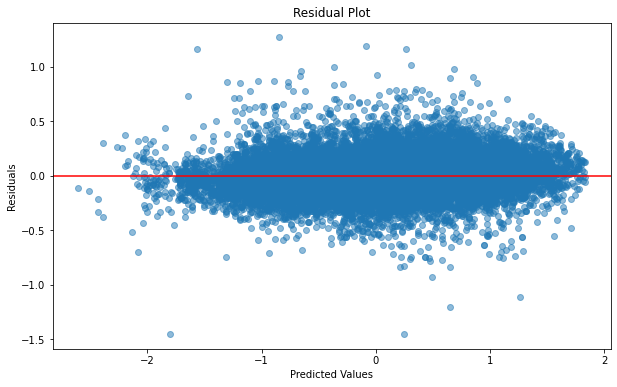

In [278]:
# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [267]:
true_prices = data_inflated.loc[X_test.index, "prices"]

In [242]:
x= scaler.inverse_transform([y_pred])
x = inv_boxcox(x, lambda_fitted) * 10000000
x = x.reshape(-1,1)

final_pred = []
for i in range(len(x)):
    final_pred.append(x[i][0] * (data_inflated.loc[data_inflated.loc[X_test.index].index[i], "CPI"] / cpi_2024_base))

final_pred

[750911.2082478225,
 760429.3977498482,
 2420802.1917183776,
 1602227.2660593854,
 3671128.961499344,
 2731870.5015694476,
 11526648.903507989,
 623262.6752887061,
 909010.1261089299,
 3052569.1594237476,
 11873632.240621144,
 1295401.4855301287,
 1169925.1204299552,
 5073906.043829948,
 715236.8141830349,
 810405.3449058505,
 8375841.517964133,
 3152923.202160677,
 2195508.1992868003,
 1533189.4711530637,
 2524341.954190926,
 2903464.180186758,
 751968.3908400156,
 5826763.144478111,
 8259887.758272174,
 286064.95518803655,
 1365880.389699788,
 424996.59746411233,
 4398735.609016686,
 826118.1456652393,
 7618716.616121978,
 1065086.184010905,
 7816150.301477172,
 2001951.8481268943,
 9512898.242519496,
 12858974.618386997,
 711825.0834140616,
 3337324.303578457,
 12978568.37807303,
 8918133.135459589,
 492830.4133081691,
 2856820.5623414204,
 164647.23136457024,
 459900.4941918552,
 408202.2287517844,
 10706976.364991117,
 1232044.4492163248,
 1527189.994408911,
 1020200.7506424887,
 

In [278]:
residuals= []
for i in range(len(final_pred)):
    residuals.append(final_pred[i] - true_prices.values[i])
print(np.quantile(residuals, .95))
print(np.quantile(residuals, .50))
print(np.quantile(residuals, .05))

950612.7317552515
3989.2713246408966
-1742120.0944894673


In [279]:
import joblib
joblib.dump(model, 'XGBRegressor.joblib')

['XGBRegressor.joblib']